# Density Estimation: Gaussian Mixture Models
# 密度估计：高斯混合模型

Credits: Forked from [PyCon 2015 Scikit-learn Tutorial](https://github.com/jakevdp/sklearn_pycon2015) by Jake VanderPlas

致谢：派生自 Jake VanderPlas 的 [PyCon 2015 Scikit-learn 教程](https://github.com/jakevdp/sklearn_pycon2015)

Here we'll explore **Gaussian Mixture Models**, which is an unsupervised clustering & density estimation technique.
在这里，我们将探讨 **高斯混合模型**，这是一种无监督的聚类和密度估计算法。

We'll start with our standard set of initial imports

我们将从标准的初始导入开始

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

## Introducing Gaussian Mixture Models
## 高斯混合模型简介

We previously saw an example of K-Means, which is a clustering algorithm which is most often fit using an expectation-maximization approach.
我们之前看到了 K-Means 的一个例子，它是一种聚类算法，最常用期望最大化方法来拟合。

Here we'll consider an extension to this which is suitable for both **clustering** and **density estimation**.
在这里，我们将考虑对此的扩展，它既适用于 **聚类** 又适用于 **密度估计**。

For example, imagine we have some one-dimensional data in a particular distribution:

例如，假设我们在一个特定的分布中有一些一维数据：

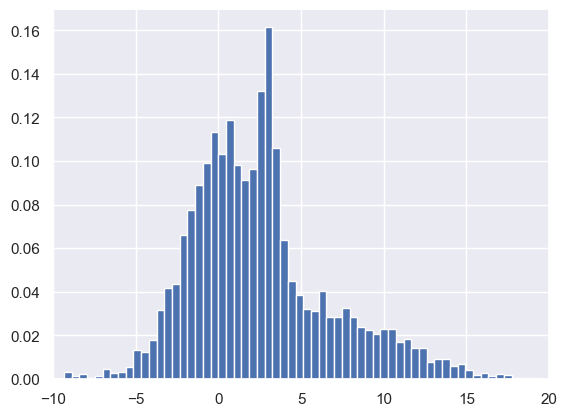

In [3]:
np.random.seed(2)
x = np.concatenate([np.random.normal(0, 2, 2000),
                    np.random.normal(5, 5, 2000),
                    np.random.normal(3, 0.5, 600)])
plt.hist(x, 80, density=True)
plt.xlim(-10, 20);

In [4]:
print(x.shape)

(4600,)


Gaussian mixture models will allow us to approximate this density:

高斯混合模型可以让我们近似这个密度：

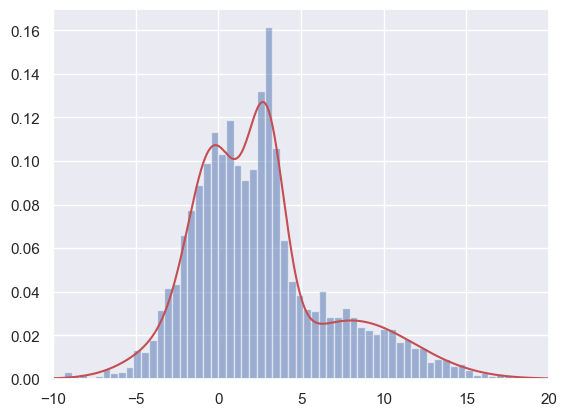

In [5]:
from sklearn.mixture import GaussianMixture
clf = GaussianMixture(4, max_iter=500, random_state=3).fit(x.reshape(-1, 1))
xpdf = np.linspace(-10, 20, 1000)
density = np.exp(clf.score_samples(xpdf.reshape(-1, 1)))

plt.hist(x, 80, density=True, alpha=0.5)
plt.plot(xpdf, density, '-r')
plt.xlim(-10, 20);

Note that this density is fit using a **mixture of Gaussians**, which we can examine by looking at the ``means_``, ``covars_``, and ``weights_`` attributes:

请注意，此密度是使用**混合高斯**进行拟合的，我们可以通过查看“means_”、“covars_”和“weights_”属性来检查：

In [6]:
clf.means_

array([[ 8.04894855],
       [-0.26509542],
       [ 2.87628921],
       [-1.762037  ]])

In [7]:
clf.covariances_

array([[[14.2611261 ]],

       [[ 2.1852085 ]],

       [[ 1.25253655]],

       [[ 7.39304484]]])

In [8]:
clf.weights_

array([0.2532411 , 0.31029078, 0.28492403, 0.15154409])

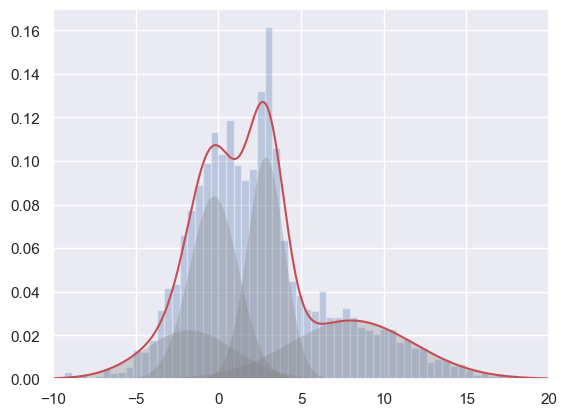

In [9]:
plt.hist(x, 80, density=True, alpha=0.3)
plt.plot(xpdf, density, '-r')

for i in range(clf.n_components):
    pdf = clf.weights_[i] * stats.norm(clf.means_[i, 0],
                                       np.sqrt(clf.covariances_[i, 0])).pdf(xpdf)
    plt.fill(xpdf, pdf, facecolor='gray',
             edgecolor='none', alpha=0.3)
plt.xlim(-10, 20);

These individual Gaussian distributions are fit using an expectation-maximization method, much as in K means, except that rather than explicit cluster assignment, the **posterior probability** is used to compute the weighted mean and covariance.
这些单独的高斯分布是使用期望最大化方法拟合的，就像在 K-Means 中一样，只是它不使用显式的簇分配，而是使用 **后验概率** 来计算加权平均值和协方差。

Somewhat surprisingly, this algorithm **provably** converges to the optimum (though the optimum is not necessarily global).

有点令人惊讶的是，该算法 **可证明** 收敛到最优点（尽管最优点不一定是全局的）。

## How many Gaussians? 有多少个高斯分布？

Given a model, we can use one of several means to evaluate how well it fits the data.

给定一个模型，我们可以使用几种方法之一来评估它与数据的拟合程度。

For example, there is the Aikaki Information Criterion (AIC) and the Bayesian Information Criterion (BIC)

例如，Aikaki 信息准则 (AIC) 和贝叶斯信息准则 (BIC)

In [10]:
print(clf.bic(x.reshape(-1, 1)))
print(clf.aic(x.reshape(-1, 1)))

25825.2019102245
25754.42998281725


Let's take a look at these as a function of the number of gaussians:

让我们看看这些作为高斯数量的函数：

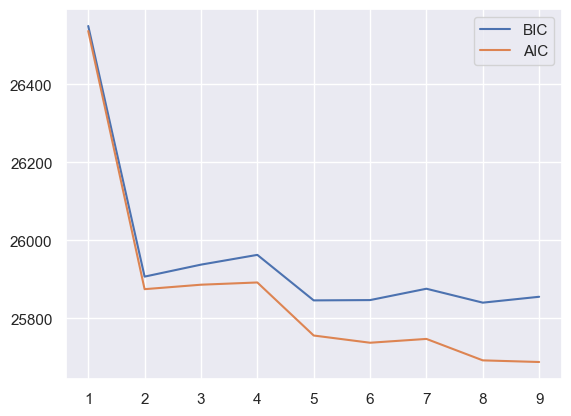

In [11]:
n_estimators = np.arange(1, 10)
clfs = [GaussianMixture(n, max_iter=1000).fit(x.reshape(-1, 1)) for n in n_estimators]
bics = [clf.bic(x.reshape(-1, 1)) for clf in clfs]
aics = [clf.aic(x.reshape(-1, 1)) for clf in clfs]

plt.plot(n_estimators, bics, label='BIC')
plt.plot(n_estimators, aics, label='AIC')
plt.legend();

It appears that for both the AIC and BIC, 4 components is preferred.

对于 AIC 和 BIC，似乎首选 4 个分量。

## Example: GMM For Outlier Detection GMM 用于异常值检测

GMM is what's known as a **Generative Model**: it's a probabilistic model from which a dataset can be generated.

GMM 即所谓的**生成模型**：它是一个概率模型，可以从中生成数据集。

One thing that generative models can be useful for is **outlier detection**: we can simply evaluate the likelihood of each point under the generative model; the points with a suitably low likelihood (where "suitable" is up to your own bias/variance preference) can be labeld outliers.

生成模型的一个用途是**异常值检测**：我们可以简单地评估生成模型下每个点的似然值；那些似然值足够低的点（“合适”取决于你自己的偏差/方差偏好）可以标记为异常值。

Let's take a look at this by defining a new dataset with some outliers:

让我们通过定义一个包含一些异常值的新数据集来看一下：

In [12]:
np.random.seed(0)

# Add 20 outliers
true_outliers = np.sort(np.random.randint(0, len(x), 20))
y = x.copy()
y[true_outliers] += 50 * np.random.randn(20)

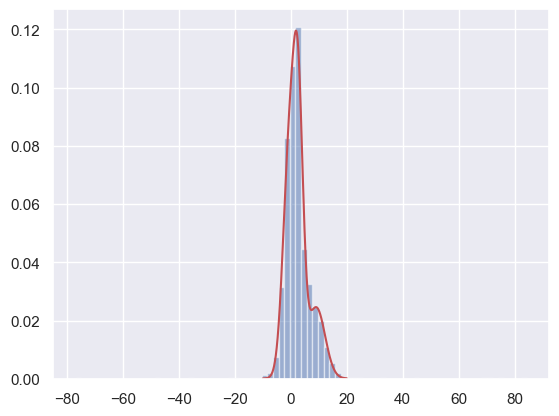

In [25]:
clf = GaussianMixture(4, max_iter=500, random_state=0).fit(y.reshape(-1, 1))
xpdf = np.linspace(-10, 20, 1000)
density_noise = np.exp(clf.score_samples(xpdf.reshape(-1, 1)))

plt.hist(y, 80, density=True, alpha=0.5)
plt.plot(xpdf, density_noise, '-r')
# plt.xlim(-15, 20);

Now let's evaluate the log-likelihood of each point under the model, and plot these as a function of ``y``:

现在，让我们评估模型下每个点的对数似然，并将这些绘制为 ``y`` 的函数：

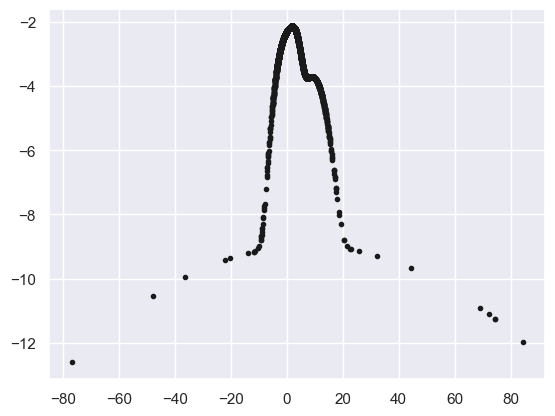

In [26]:
log_likelihood = clf.score_samples(y.reshape(-1,1))
plt.plot(y, log_likelihood, '.k');

In [27]:
detected_outliers = np.where(log_likelihood < -9)[0]

print("true outliers:")
print(true_outliers)
print("\ndetected outliers:")
print(detected_outliers)

true outliers:
[  99  537  705 1033 1653 1701 1871 2046 2135 2163 2222 2496 2599 2607
 2732 2893 2897 3264 3468 4373]

detected outliers:
[  99  537  705 1653 2046 2130 2135 2163 2222 2496 2724 2732 2893 2897
 3067 3173 3253 3468 3483 4373]


The algorithm misses a few of these points, which is to be expected (some of the "outliers" actually land in the middle of the distribution!)

算法漏掉了其中一些点，这是意料之中的（一些“异常值”实际上位于分布的中间！）

Here are the outliers that were missed:

以下是被漏掉的异常值：

In [ ]:
set(true_outliers) - set(detected_outliers)

{np.int32(1033),
 np.int32(1701),
 np.int32(1871),
 np.int32(2599),
 np.int32(2607),
 np.int32(3264)}

And here are the non-outliers which were spuriously labeled outliers:

以下是被错误地标记为异常值的非异常值：

In [29]:
set(detected_outliers) - set(true_outliers)

{np.int64(2130),
 np.int64(2724),
 np.int64(3067),
 np.int64(3173),
 np.int64(3253),
 np.int64(3483)}

Finally, we should note that although all of the above is done in one dimension, GMM does generalize to multiple dimensions, as we'll see in the breakout session.

最后，我们应该注意到，尽管以上所有内容都是在一个维度上完成的，但 GMM 确实可以推广到多个维度，正如我们将在分组讨论中看到的那样。

## Other Density Estimators
## 其他密度估计器

The other main density estimator that you might find useful is *Kernel Density Estimation*, which is available via ``sklearn.neighbors.KernelDensity``. In some ways, this can be thought of as a generalization of GMM where there is a gaussian placed at the location of *every* training point!

您可能会发现有用的另一个主要密度估计器是 *核密度估计*，可通过 ``sklearn.neighbors.KernelDensity`` 获得。在某些方面，这可以被认为是 GMM 的推广，其中在 *每个* 训练点的位置都放置一个高斯分布！

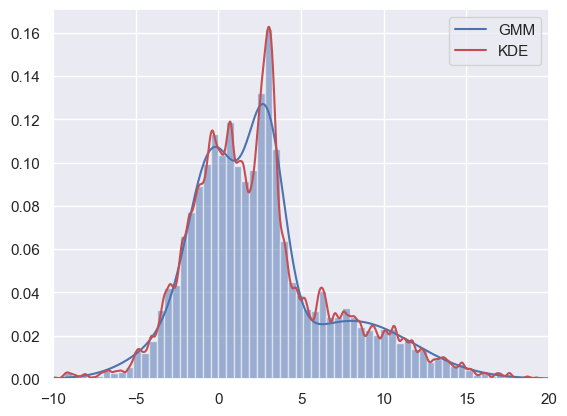

In [ ]:
from sklearn.neighbors import KernelDensity
kde = KernelDensity(bandwidth=0.15)
kde.fit(x[:, None])
density_kde = np.exp(kde.score_samples(xpdf[:, None]))

plt.hist(x, 80, density=True, alpha=0.5)
plt.plot(xpdf, density, '-b', label='GMM')
plt.plot(xpdf, density_kde, '-r', label='KDE')
plt.xlim(-10, 20)
plt.legend()

All of these density estimators can be viewed as **Generative models** of the data: that is, that is, the model tells us how more data can be created which fits the model.

所有这些密度估计器都可以看作是数据的**生成模型**：也就是说，模型告诉我们如何创建更多适合该模型的数据。